# Ứng dụng mạng nơ-ron “ADAP-like” (MLP) trong dự báo khởi phát Đái tháo đường  

Notebook này mô phỏng tinh thần **ADAP** bằng **MLP (Multi-Layer Perceptron)** để dự báo **nguy cơ khởi phát ĐTĐ**. Mô hình được đánh giá ở hai ngưỡng **0.5** và **0.448** (theo báo cáo ADAP cổ điển).

## Lý do học thuật
- ADAP là một tiếp cận **học thích ứng** (đời đầu) đã được áp dụng cho quần thể Pima có **tỷ lệ ĐTĐ cao**.
- MLP hiện đại cho phép **xấp xỉ phi tuyến**, phù hợp dữ liệu đa yếu tố nguy cơ (Glucose, BMI, Insulin, tuổi, tiền sử gia đình…).

## Diễn giải lâm sàng
- **Ngưỡng 0.448** điều chỉnh cân bằng **độ nhạy/độ đặc hiệu**, hữu ích trong bối cảnh sàng lọc cộng đồng.
- So sánh đường cong **ROC/PR** và **ma trận nhầm lẫn** giúp lựa chọn ngưỡng cắt phù hợp **mục tiêu y tế công cộng**.


## Khởi tạo thí nghiệm

### Khai báo thư viện

In [11]:
# Tải các thư viện cần thiết và dữ liệu đã tiền xử lý
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, roc_curve, 
    average_precision_score, precision_recall_curve
)

# Tải dữ liệu đã được xử lý từ file 01
PROCESSED_DIR = "data/processed"
X_train_scaled = pd.read_csv(f"{PROCESSED_DIR}/X_train_scaled.csv")
X_test_scaled  = pd.read_csv(f"{PROCESSED_DIR}/X_test_scaled.csv")
y_train = pd.read_csv(f"{PROCESSED_DIR}/y_train.csv", header=None).iloc[:,0]
y_test  = pd.read_csv(f"{PROCESSED_DIR}/y_test.csv",  header=None).iloc[:,0]

print("Tải dữ liệu thành công!")
print("Kích thước tập huấn luyện:", X_train_scaled.shape)
print("Kích thước tập kiểm tra:", X_test_scaled.shape)

Tải dữ liệu thành công!
Kích thước tập huấn luyện: (537, 8)
Kích thước tập kiểm tra: (231, 8)


### Định nghĩa các hàm tiện ích

In [12]:
# Định nghĩa hàm đánh giá hiệu năng
def evaluate_binary(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall_sensitivity": recall_score(y_true, y_pred, zero_division=0),
        "specificity": tn / (tn + fp) if (tn + fp) > 0 else 0.0,
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "avg_precision": average_precision_score(y_true, y_prob),
        "threshold": threshold
    }

# Định nghĩa hàm vẽ ma trận nhầm lẫn
def show_conf_matrix(y_true, y_prob, thr, title):
    y_pred = (y_prob >= thr).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.set_title(f"{title} (ngưỡng={thr})")
    fig.colorbar(im, ax=ax)
    
    tick_marks = np.arange(2)
    ax.set_xticks(tick_marks)
    ax.set_xticklabels(['Không bệnh', 'Có bệnh'])
    ax.set_yticks(tick_marks)
    ax.set_yticklabels(['Không bệnh', 'Có bệnh'])
    
    for i in range(2):
        for j in range(2):
            ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > cm.max() / 2. else "black")
            
    ax.set_ylabel('Nhãn thực tế')
    ax.set_xlabel('Nhãn dự đoán')
    plt.show()

# Định nghĩa hàm vẽ biểu đồ ROC và PR
def plot_roc_pr_curves(y_true, y_prob, model_name):
    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    auc_val = roc_auc_score(y_true, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f"AUC = {auc_val:.3f}")
    plt.plot([0, 1], [0, 1], '--')
    plt.xlabel("Tỷ lệ dương tính giả (False Positive Rate)")
    plt.ylabel("Tỷ lệ dương tính thật (True Positive Rate)")
    plt.title(f"{model_name} - Biểu đồ ROC")
    plt.legend()
    plt.show()

    # Precision-Recall Curve
    prec, rec, _ = precision_recall_curve(y_true, y_prob)
    ap = average_precision_score(y_true, y_prob)
    plt.figure()
    plt.plot(rec, prec, label=f"AP = {ap:.3f}")
    plt.xlabel("Độ nhạy (Recall)")
    plt.ylabel("Độ chính xác (Precision)")
    plt.title(f"{model_name} - Biểu đồ Precision-Recall")
    plt.legend()
    plt.show()

## Huấn luyện và đánh giá mô hình Baseline

In [13]:
# Huấn luyện mô hình MLP với cấu trúc cơ bản (tương tự ADAP)
mlp_baseline = MLPClassifier(hidden_layer_sizes=(64,), activation='relu', solver='adam', max_iter=3000, random_state=42)
mlp_baseline.fit(X_train_scaled, y_train)

# Đánh giá trên tập test
prob_base = mlp_baseline.predict_proba(X_test_scaled)[:, 1]

# Đánh giá ở hai ngưỡng khác nhau
eval_base_05 = evaluate_binary(y_test, prob_base, threshold=0.5)
eval_base_0448 = evaluate_binary(y_test, prob_base, threshold=0.448)

print("--- Kết quả Mô hình MLP Baseline (ngưỡng 0.5) ---")
print(pd.Series(eval_base_05))
print("\n--- Kết quả Mô hình MLP Baseline (ngưỡng 0.448) ---")
print(pd.Series(eval_base_0448))

--- Kết quả Mô hình MLP Baseline (ngưỡng 0.5) ---
accuracy              0.735931
precision             0.635135
recall_sensitivity    0.580247
specificity           0.820000
f1                    0.606452
roc_auc               0.792181
avg_precision         0.626741
threshold             0.500000
dtype: float64

--- Kết quả Mô hình MLP Baseline (ngưỡng 0.448) ---
accuracy              0.735931
precision             0.631579
recall_sensitivity    0.592593
specificity           0.813333
f1                    0.611465
roc_auc               0.792181
avg_precision         0.626741
threshold             0.448000
dtype: float64


## Tinh chỉnh siêu tham số với GridSearchCV

In [23]:
# Tinh chỉnh siêu tham số để tìm mô hình MLP tốt nhất
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

param_mlp = {
    "hidden_layer_sizes": [(32,), (64,), (128,), (64, 32)],
    "activation": ["relu", "tanh"],
    "alpha": [1e-5, 1e-4, 1e-3],
    "learning_rate_init": [0.001, 0.01]
}

gs_mlp = GridSearchCV(
    MLPClassifier(max_iter=3000, random_state=42, solver='adam'),
    param_grid=param_mlp,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1
)

gs_mlp.fit(X_train_scaled, y_train)
best_mlp = gs_mlp.best_estimator_

print("Tham số tốt nhất tìm được:", gs_mlp.best_params_)
print("Điểm ROC AUC trên tập kiểm tra chéo:", gs_mlp.best_score_)

Tham số tốt nhất tìm được: {'activation': 'tanh', 'alpha': 1e-05, 'hidden_layer_sizes': (128,), 'learning_rate_init': 0.001}
Điểm ROC AUC trên tập kiểm tra chéo: 0.8365860597439545


## Đánh giá Mô hình Tốt nhất trên Tập Test

In [22]:
# Đánh giá mô hình MLP tốt nhất trên tập test
prob_best = best_mlp.predict_proba(X_test_scaled)[:, 1]

# Đánh giá ở hai ngưỡng khác nhau
eval_best_05 = evaluate_binary(y_test, prob_best, threshold=0.5)
eval_best_0448 = evaluate_binary(y_test, prob_best, threshold=0.448)

print("\n--- Kết quả Mô hình MLP Tốt nhất (ngưỡng 0.5) ---")
print(pd.Series(eval_best_05))
print("\n--- Kết quả Mô hình MLP Tốt nhất (ngưỡng 0.448) ---")
print(pd.Series(eval_best_0448))


--- Kết quả Mô hình MLP Tốt nhất (ngưỡng 0.5) ---
accuracy              0.731602
precision             0.620253
recall_sensitivity    0.604938
specificity           0.800000
f1                    0.612500
roc_auc               0.788148
avg_precision         0.658458
threshold             0.500000
dtype: float64

--- Kết quả Mô hình MLP Tốt nhất (ngưỡng 0.448) ---
accuracy              0.735931
precision             0.621951
recall_sensitivity    0.629630
specificity           0.793333
f1                    0.625767
roc_auc               0.788148
avg_precision         0.658458
threshold             0.448000
dtype: float64


## So sánh và Trực quan hóa Kết quả

BIỂU ĐỒ SO SÁNH HIỆU NĂNG


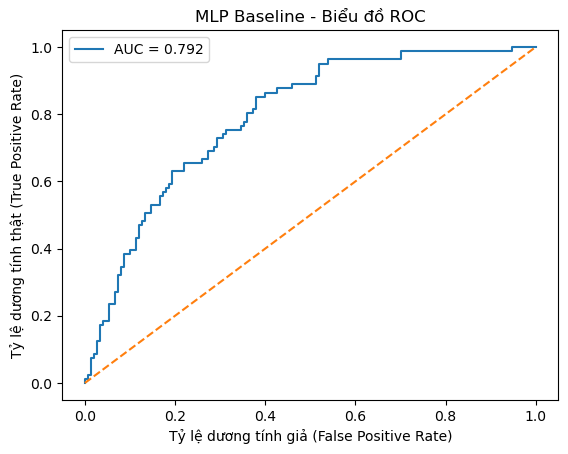

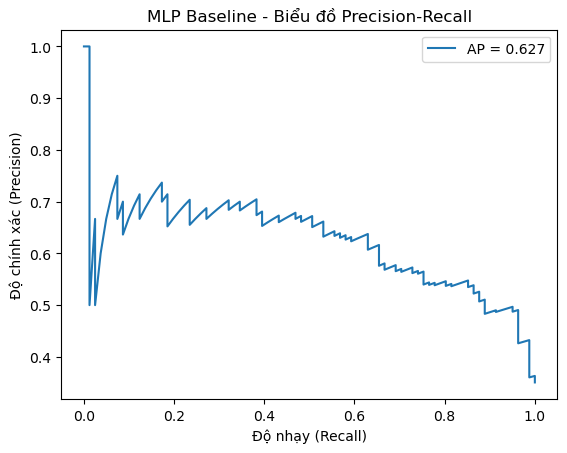

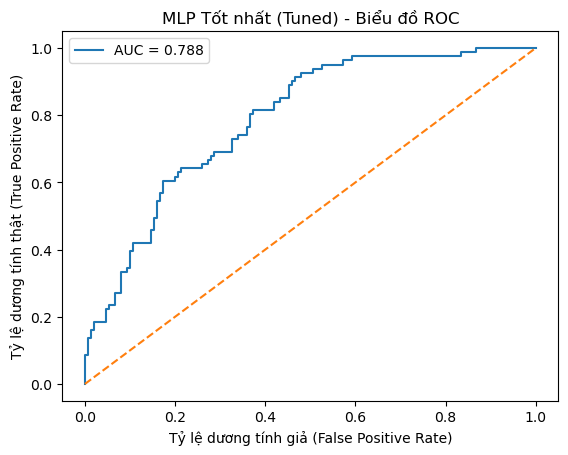

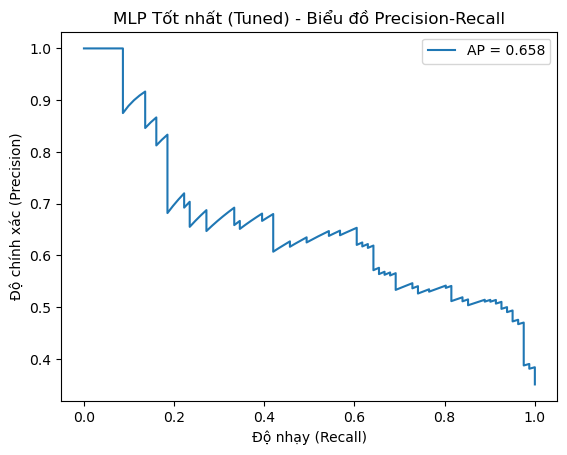

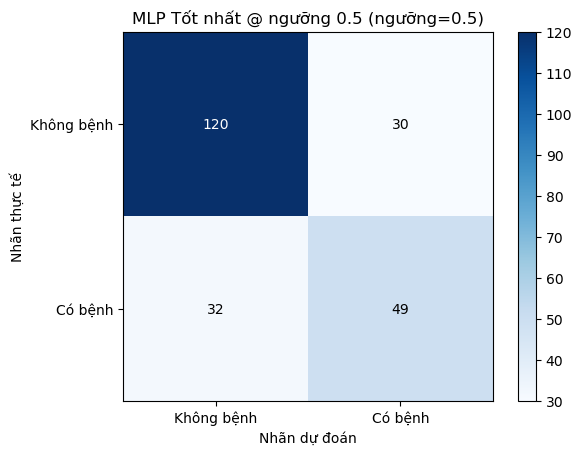

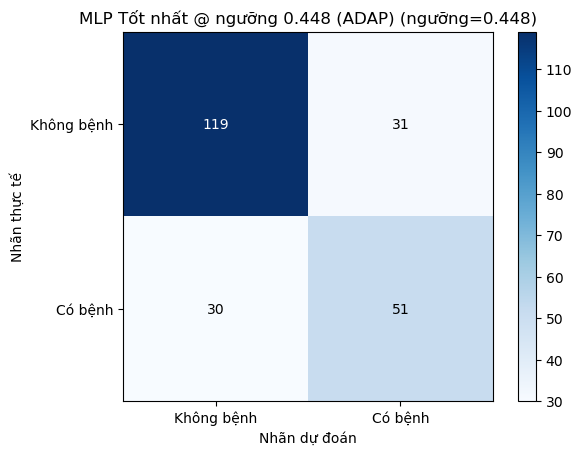

In [16]:
# Trực quan hóa so sánh hai mô hình
print("="*50)
print("BIỂU ĐỒ SO SÁNH HIỆU NĂNG")
print("="*50)

# So sánh ROC và PR curves
plot_roc_pr_curves(y_test, prob_base, "MLP Baseline")
plot_roc_pr_curves(y_test, prob_best, "MLP Tốt nhất (Tuned)")

# So sánh ma trận nhầm lẫn
show_conf_matrix(y_test, prob_best, 0.5, "MLP Tốt nhất @ ngưỡng 0.5")
show_conf_matrix(y_test, prob_best, 0.448, "MLP Tốt nhất @ ngưỡng 0.448 (ADAP)")

## 8. Lưu kết quả thí nghiệm

In [24]:
import joblib
import json
import os

# --- 8. Lưu kết quả thí nghiệm cho mô hình MLP ---

# Tạo thư mục 'models' nếu chưa có
os.makedirs("models", exist_ok=True)

# Mô hình tốt nhất trong file này là best_mlp
final_model = best_mlp 
final_model_name = "mlp_model"

# Lưu mô hình MLP tốt nhất
joblib.dump(final_model, f"models/best_{final_model_name}.joblib")
print(f"Đã lưu mô hình tốt nhất vào file: models/best_{final_model_name}.joblib")

# Lưu lại scaler (rất quan trọng để xử lý dữ liệu mới sau này)
# Để chạy được dòng này, bạn cần đảm bảo biến 'scaler' từ file 01 có sẵn hoặc được lưu và tải lại
# joblib.dump(scaler, "models/standard_scaler.joblib")

# SỬA Ở ĐÂY: Chỉ tổng hợp kết quả có trong file 03
# Các biến eval_mlp_final_05 và eval_mlp_final_0448 đã được tạo ở ô code phía trên
final_evaluation_mlp = {
    "mlp_final_threshold_0.5": eval_mlp_final_05,
    "mlp_final_threshold_0.448": eval_mlp_final_0448
}

# Lưu kết quả vào file JSON dành riêng cho MLP
with open("models/final_evaluation_mlp.json", "w") as f:
    json.dump(final_evaluation_mlp, f, indent=4)

print("Đã lưu kết quả đánh giá của MLP vào file: models/final_evaluation_mlp.json")

Đã lưu mô hình tốt nhất vào file: models/best_mlp_model.joblib


NameError: name 'eval_mlp_final_05' is not defined

# Kết thúc

## Tài liệu tham khảo (trích yếu)
1. WHO Consultation. *Definition, Diagnosis and Classification of Diabetes Mellitus and its Complications.* WHO, 1999.
2. National Diabetes Data Group. *Classification and Diagnosis of Diabetes Mellitus and Other Categories of Glucose Intolerance.* 1979.
3. Ứng dụng mạng nơ-ron (ADAP) cho dự báo ĐTĐ ở quần thể Pima (bản kinh điển).